# Tree Models for Natural 10+ Acre Fires

A=0-0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres

In [2]:
%matplotlib inline

from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import all_col_queries

In [22]:
df_fires = all_col_queries.get_df()

df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month'])
scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class >= 'C'

X_train_unbal, X_test, y_train_unbal, y_test = train_test_split(X, y, random_state=42)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_unbal, y_train_unbal)

num_fires = (y_train == True).sum()
num_data_pt = len(y_train)
print(f'Train data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie balanced)')
num_fires = (y_test == True).sum()
num_data_pt = len(y_test)
print(f'Test data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

Train data: no fires 50.0% of the time (ie balanced)
Test data: no fires 96.0% of the time (ie unbalanced)
X_train: 277866, X_test: 48165, y_train: 277866, y_test: 48165


In [23]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'10+ acre fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification (10+ acre fires) ---------')
print(classification_report(y_test, y_pred_log_reg))

10+ acre fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.99      0.60      0.74     46268
        True       0.07      0.78      0.13      1897

    accuracy                           0.60     48165
   macro avg       0.53      0.69      0.44     48165
weighted avg       0.95      0.60      0.72     48165



In [24]:
import xgboost

# params = {
#     'objective': ['binary:logistic'],
#     'max_depth': [3, 6, 9],
#     'gamma': [0, 0.1, 0.4],
#     # 'subsample': [0.5],
#     # 'colsample_bytree': [0.1],
#     # 'colsample_bylevel': [1.0],
#     'learning_rate': [0.1, 0.2],
#     'n_estimators': [200],
#     'eval_metric': ['logloss']
# }
params = {'eval_metric': ['logloss'], 'gamma': [0], 'learning_rate': [0.1],
          'max_depth': [9], 'n_estimators': [200], 'objective': ['binary:logistic']}

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)
xgb = GridSearchCV(estimator=xgb, scoring="recall", param_grid=params)

xgb.fit(X_train, y_train)

print("10+ acre best Params:", xgb.best_params_)

y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report (10+ acre fires) ---------')
print(classification_report(y_test, y_pred_xgb))

10+ acre best Params: {'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
--------- XGBoost Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.97      0.95      0.96     46268
        True       0.25      0.40      0.31      1897

    accuracy                           0.93     48165
   macro avg       0.61      0.67      0.64     48165
weighted avg       0.95      0.93      0.94     48165



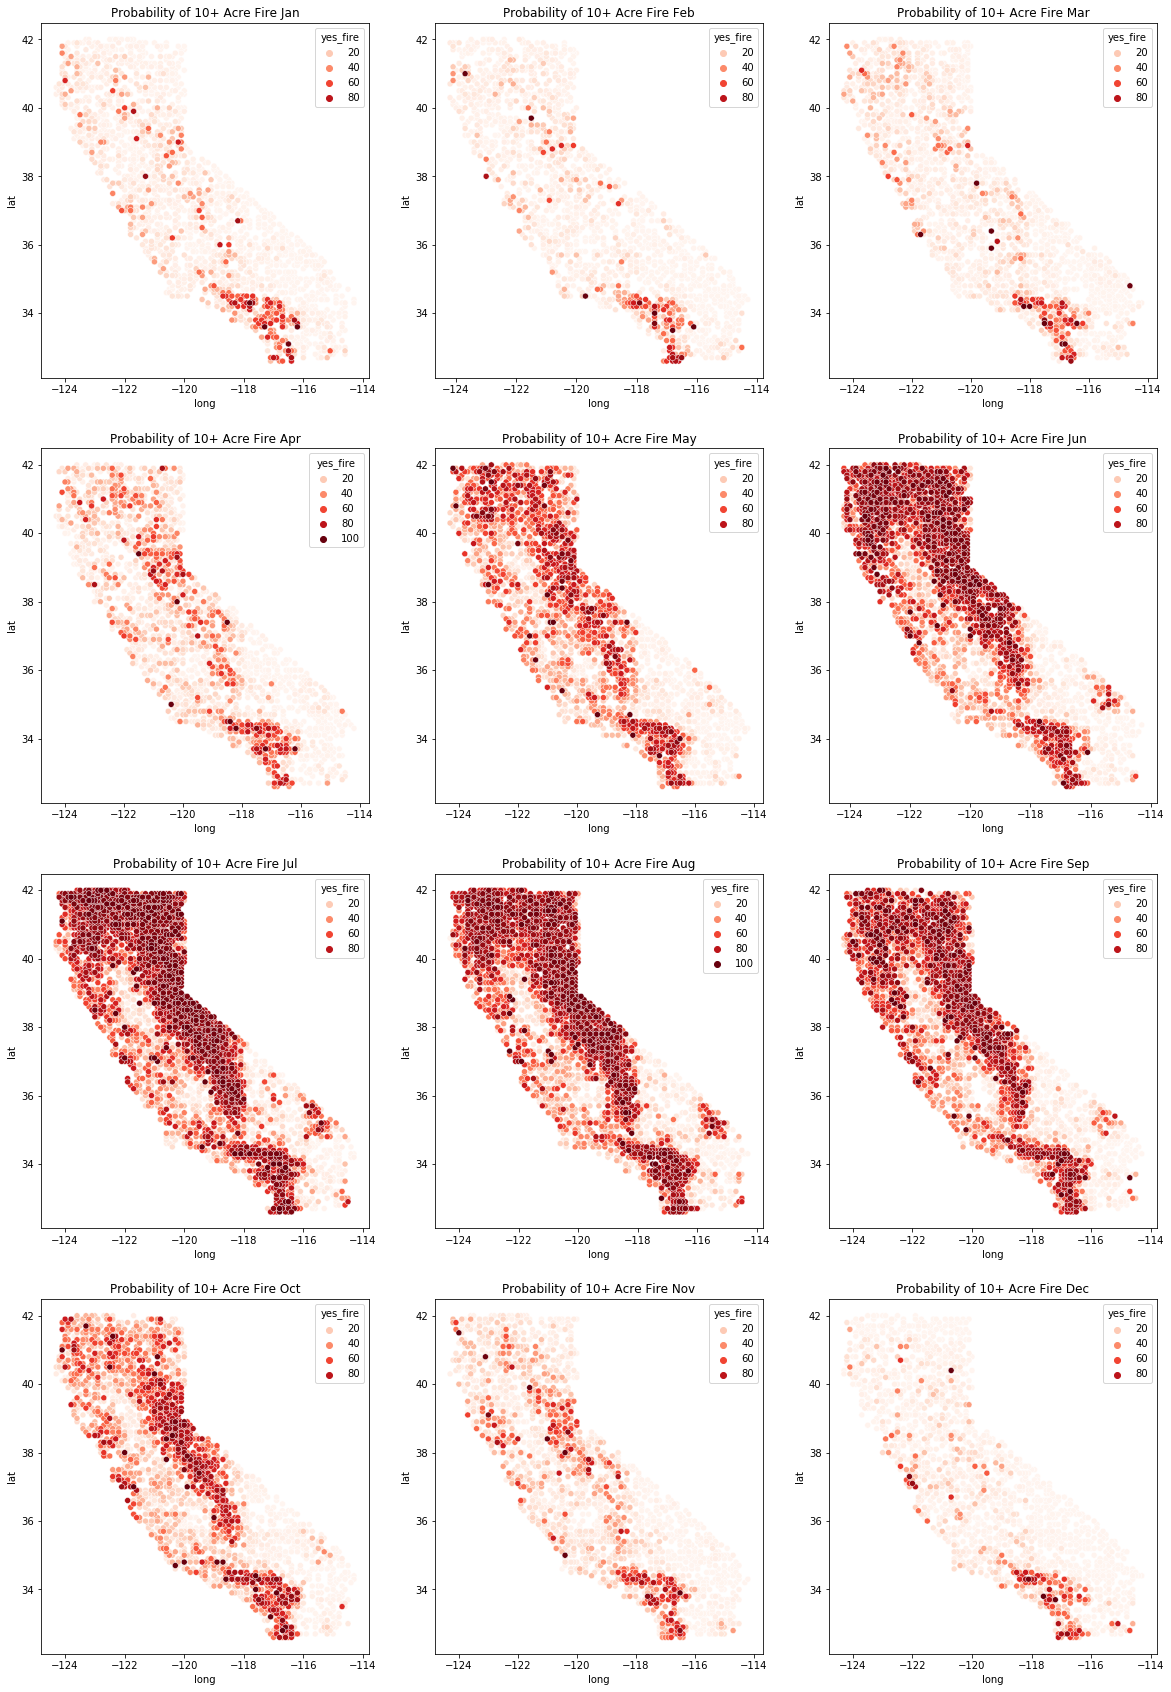

In [28]:
import datetime

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(df_fires, df_fires.fire_size_class >= 'C', random_state=42)
X_orig_test = X_orig_test.reset_index(drop=True)
proba_xgb = pd.DataFrame(xgb.predict_proba(X_test), columns=['no_fire', 'yes_fire'])
proba_xgb = pd.concat([X_orig_test, proba_xgb], axis=1)
proba_xgb['yes_fire'] = proba_xgb.yes_fire * 100
proba_xgb = proba_xgb.drop(columns=proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
proba_month = proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index().sort_values('yes_fire')

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of 10+ Acre Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=proba_month[proba_month.month == i], palette='Reds', hue='yes_fire')

In [26]:
import lightgbm as lgb

gbm = lgb.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.5, 0.8, 1.2],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_f

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.5, 0.8,
                                                          1.2],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                  

In [27]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report (10+ acre fires) ---------')
print(classification_report(y_test, y_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 20, 'min_data_in_leaf': 1800, 'metric': 'binary_logloss', 'max_depth': 8, 'max_bin': 300, 'learning_rate': 0.8, 'feature_fraction': 0.2, 'bagging_freq': 5, 'bagging_fraction': 0.7000000000000002}
--------- LightGBM Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.99      0.51      0.67     46268
        True       0.06      0.84      0.12      1897

    accuracy                           0.52     48165
   macro avg       0.53      0.67      0.39     48165
weighted avg       0.95      0.52      0.65     48165

